# Technical Report

In [9]:
from IPython.core.display import Image 

**What we're doing, and why we're doing it:**

I wanted to work with data from a game called League of Legends. It is a team versus team game, with five players on either team striving to win. There are many faucets of the game that goes into winning, some more intuitive than others. I wanted to explore one that was less intutive but still essential to wins-- the vision score.

I remember this idea was told to me as a new player but never explained well and never backed up by any concrete data. I felt that if we're able to explore the vision features of the game and find correlation between that and winning, I'd have data to back up the importance of vision score. This would be framed to help new players or players at lower ranks, but to also emphasize how it's a team effort to keep the score up. 

## Data Aquistion

The data I wanted to work with was from a game called League of Legends. I wanted to see if there was any correlation between a team's vision score and their win.  

To aquire the data, I first had to register for an API key. Once got, I had to look through the API documentation to find out where the relevant information was held. 

**API Documentation**

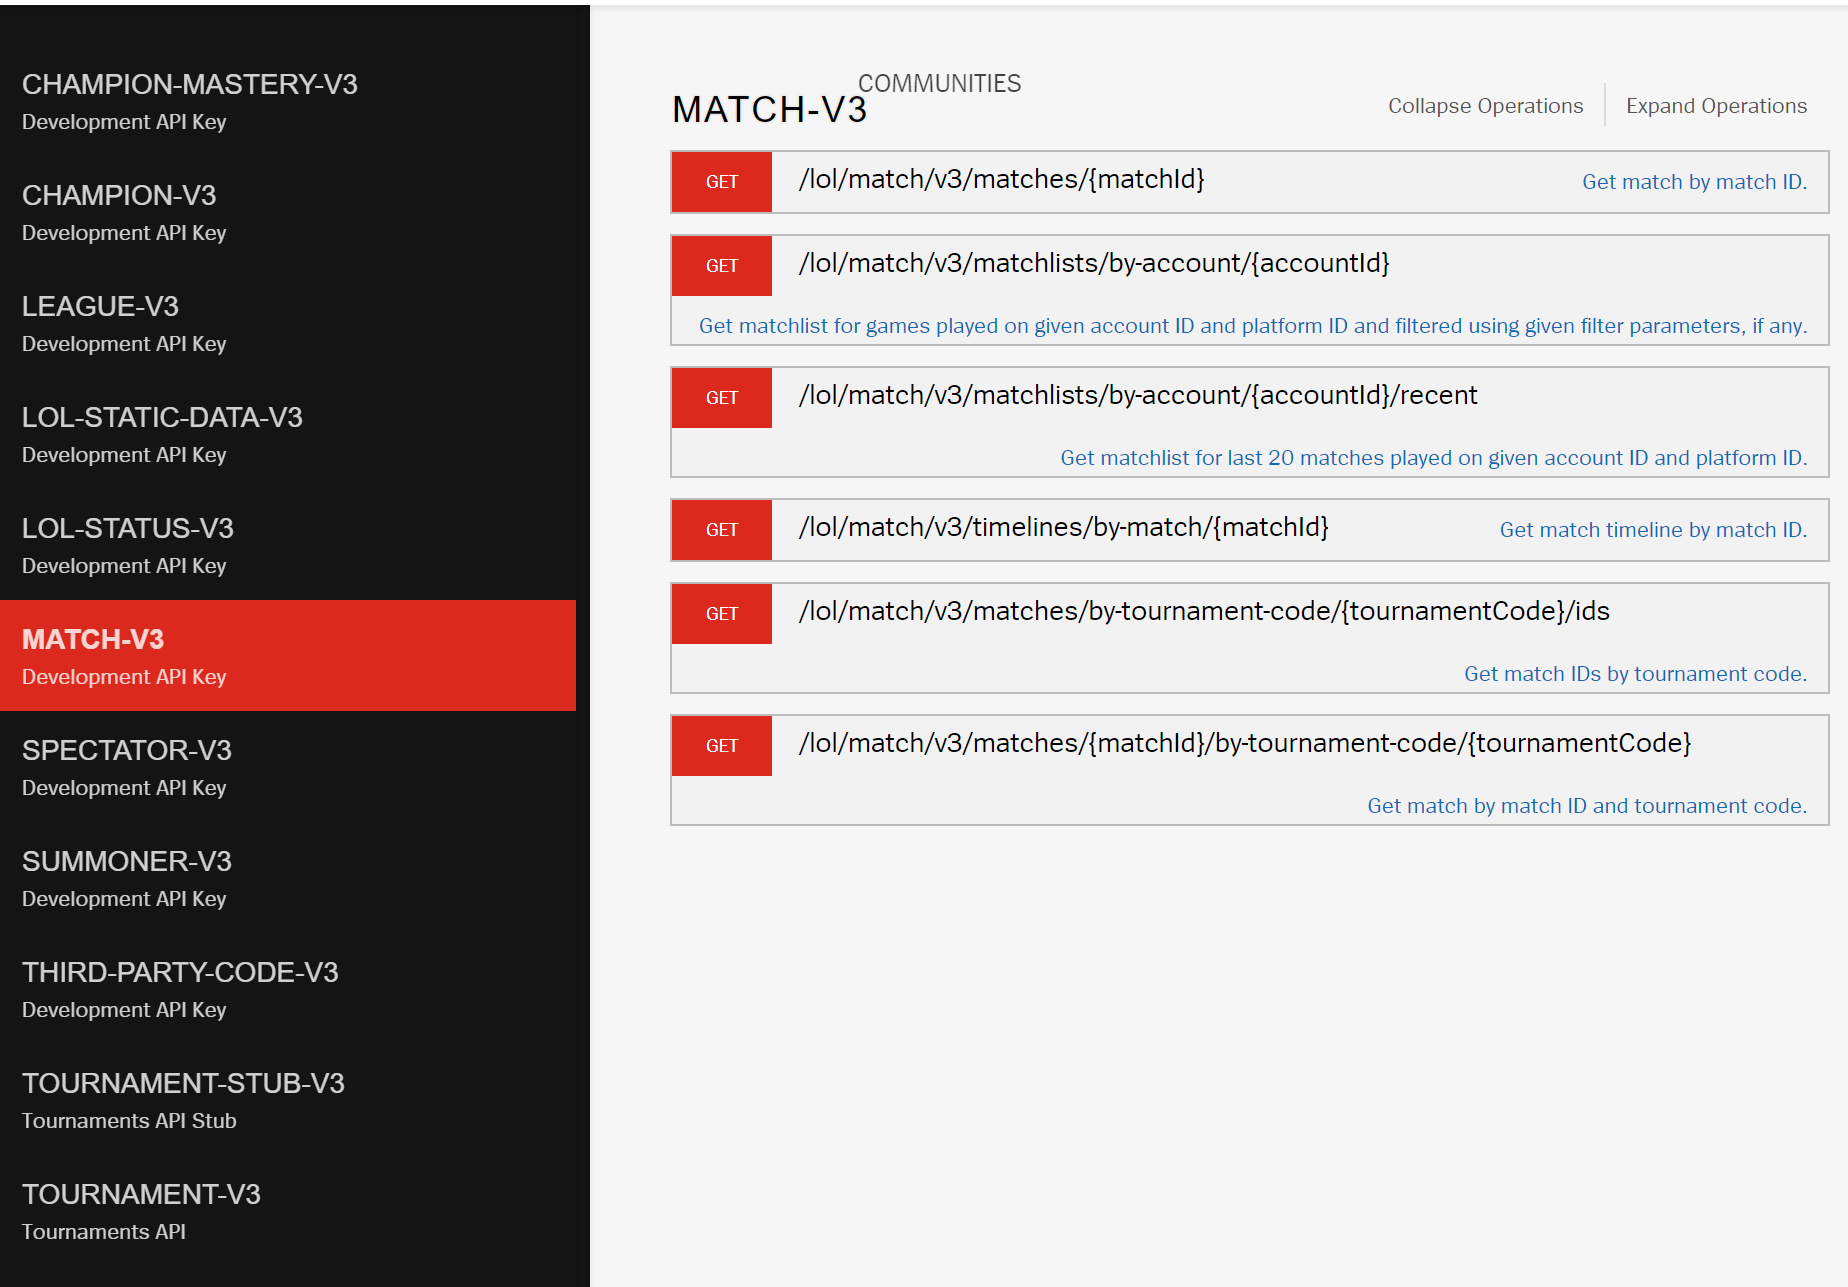

In [12]:
Image(filename='./one.png')

Each tab of the API Documentation contains the information of the tab's namesake. This information can sometimes be gotten by a simple request, and other times can be gotten by fulfilling a requirement.

For example, if I want LOL-STATIC-DATA-V3, I can go to the first request link and get the information without inputting any information on my end. 

But, this is not true for MATCH-V3 data. You can see taht every link requires a different requirement. In our case, we'll end up getting our match data through using matchId.

**Working with /lol/match/v3/matches/{matchId}**

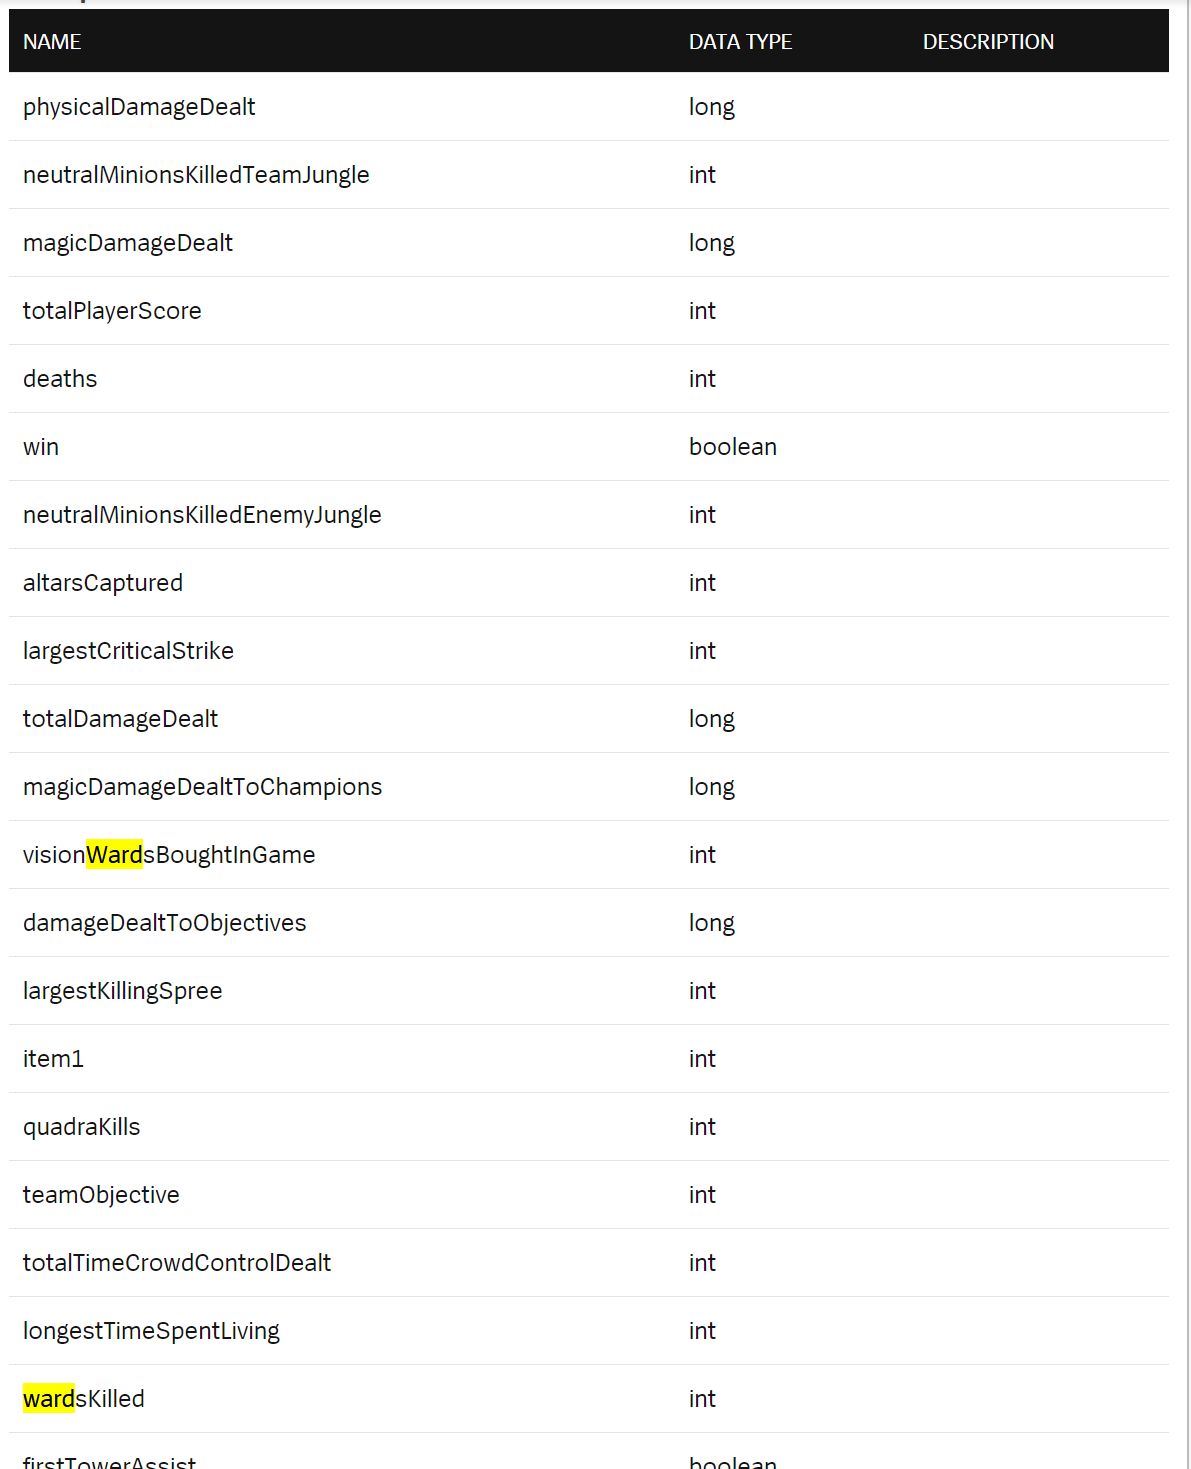

In [13]:
Image(filename='./two.png')

Each link opens to a list of information available from that link. Above is that snippet. The data type for each is conveniantly given, which I was able to use when I was gathering all the data related to vision in the game. 

Each of these labels are under a tag, which can be requested seperately. For my information, I went through three different tags for the total of eight features split by teams -- except for game duration -- to make it fifteen).

In order to get this information, I needed matchID. In order to get that, I needed gameID. And in order to get gameID... I worked backwards until I found information in a tab that had no requirements to get. 

It went like this: LEAGUE-V3 to get CHALLENGERS LEAGUE information to get PLAYER NAME and take that to SUMMONER-V3 and search by PLAYER NAME which I'd gotten earlier to get ACCOUNT ID to take to MATCH-V3 and get GAME ID where I would get MATCH ID which I could then insert into /lol/match/v3/matches/{matchId} to get the relevant information I wanted.

**Working map:**

In [ ]:
# league v3 > challengers league > player name > summoner > by name > 
# account id > match v3 > by accountid > gameId > by matchid > profit

Starting with: *league v3 > challengers league > player name > summoner > by name > account id*

%run ./one_Token.ipynb

To make sure that the Token (aka API key) didn't end up on GitHub, I put it into its own Jupyter Notebook along with a couple other recurring data that I would be using in my functions.

For any function that required the API key, I would run the above command at the beginning of the Jupyter Notebook.

**Gettings API information using Functions**

In [ ]:
SumID_List = []
# Gets the Challenger Rank Game info
def getChalle():
    request = '/lol/league/v3/challengerleagues/by-queue/RANKED_SOLO_5x5'
    response = urlopen(prefix+request+api_key+token).read().decode('utf-8')
    responseJson = json.loads(response)
    return responseJson
    
Info = getChalle()
Info

# Gets the Summoner ID from those Challenger Games
for x in Info['entries']:
    SumID_List.append(x['playerOrTeamId'])

SumID_List # List of Summoner IDs

_league v3 > challengers league > player name_

From the LEAGUE-V3 tab we can get challenger match data, including the PLAYER NAME which is what we're looking for. 

In [ ]:
# Gets Account ID
def getID(SummonerID):
    '''This will get the ACCOUNT ID (accountId)
    for the given Summoner Name (SummonerName)'''
    request = "/lol/summoner/v3/summoners/"
    response = urlopen(prefix+request+SummonerID+api_key+token).read().decode('utf-8')
    responseJson = json.loads(response)
    return responseJson.get('accountId')


AccID_List = []

for x in range(len(SumID_List)):    
    AccNum = getID(SumID_List[x])
    AccID_List.append(AccNum)

_summoner > by name > account id_

From SUMMONER-V3 tab, we can get the data by PLAYER NAME that will give us ACCOUNT ID

This is where I broke up the Jupyter Notebook file into two. To keep the Account ID data without having to ping the API again, I turned the list to a df and then saved it into a csv file. 

```AccID_df = pd.DataFrame(AccID_List, index = None, columns = ['AccID'])
AccID_df.to_csv('AccID_list2.csv', index=False)```

In [ ]:
# Part 2:
# match v3 > by accountid > gameId > by matchid > profit

After importing the Account ID df, in order to make it easily run with a function, I turned it back into a list.

```import pandas as pd
AccID_df = pd.read_csv('./AccID_list.csv')
AccID_list = []
for x in AccID_df.values:
    AccID_list.append(int(x)```

Later, I would make a function for this:

```def makelist(df, lst): 
    for x in df.values:
        lst.append(int(x))
    return lst```

In [ ]:
# Does NOT get GameID!! It gets the batch of info that HAS GameID in it. 
def getGameID(acc_id):
    request = '/lol/match/v3/matchlists/by-account/'+acc_id #change this so that it goes to get gameIDs for each AccID <--done
    response = urlopen(prefix+request+api_key+token).read().decode('utf-8')
    responseJson = json.loads(response)
    return responseJson

_match v3 > by accountid > gameId_

From the MATCH-V3, we can put our list of ACCOUNT IDs through the above function and get a batch of information where GAME ID is one of them.

In [ ]:
# Takes the BatchInfo from above and gets GameID, returns a list of these GameIDs
def make_GameID_list(BatchInfo, lst):
    for x in BatchInfo['matches']:
        lst.append(x['gameId'])
    return lst

We throw the batch information into this function, which will extract the GAME IDs and ame us a GAME ID list.

In [ ]:
# using a GameID, it gets the info of the Match of that id
def getMatch(game_id):
    request = '/lol/match/v3/matches/'+str(game_id) #change this so that it goes to get each match from gameID list <--done
    response = urlopen(prefix+request+api_key+token).read().decode('utf-8')
    responseJson = json.loads(response)
    return responseJson

From the list of GAME IDs, we can put it in this function which will give us back the match information. Match information is what we wanted all along, we're finally here!

Now we have to extract the relevant information, aka the features, that we want from the match information:

**Extracting Features**

In [ ]:
# this gets the relevant info from the MatchInfo, which is gotten from the list of GameIDs
# returns a df
def getMatchInfo(GameID_List):
    wardstot1 = 0
    wardstot2 = 0

    ccscore1 = 0
    ccscore2 = 0

    team1win = ''
    team2win = ''
    
    vscore1 = 0
    vscore2 = 0
    
    vwardbot1 = 0
    vwardbot2 = 0
    
    wardrem1 = 0
    wardrem2 = 0
    
    trinkets1 = ''
    trinkets2 = ''
    
    gamedur = 0

    data = {
        'Team1 Win?': team1win,
        'T1 Total Wards': wardstot1,
        'T1 CC Score': ccscore1,
        'Team2 Win?': team2win,
        'T2 Total Wards': wardstot2,
        'T2 CC Score': ccscore2,
        'T1 Vision Score': vscore1,
        'T2 Vision Score': vscore2,
        'T1 Vision Wards Bought': vwardbot1,
        'T2 Vision Wards Bought': vwardbot2,
        'T1 Wards Removed': wardrem1,
        'T2 Wards Removed': wardrem2,
        'T1 Trinkets': trinkets1,
        'T2 Trinkets': trinkets2,
        'Game Duration (mins)': gamedur}
    df = pd.DataFrame(data=data, index=[0])

    #     rate = 0    # as of now, not needed, only if len(list) > 100

    for g_id in GameID_List:
        matchInfo = getMatch(g_id)
        wardstot1 = 0
        wardstot2 = 0

        ccscore1 = 0
        ccscore2 = 0

        team1win = ''
        team2win = ''
        
        vscore1 = 0
        vscore2 = 0
        
        vwardbot1 = 0
        vwardbot2 = 0
        
        wardrem1 = 0
        wardrem2 = 0
        
        trinkets1 = ''
        trinkets2 = ''
        
        gamedur = 0
        
        gamedur = matchInfo['gameDuration']
        gamedur = gamedur/60
        for x in matchInfo['participants']:
            if x['participantId'] == 1:
                team1win = x['stats']['win']
            if x['participantId'] < 6:
                wardstot1 = x['stats']['wardsPlaced'] + wardstot1
                ccscore1 = x['stats']['timeCCingOthers'] + ccscore1
                vscore1 = x['stats']['visionScore'] + vscore1
                vwardbot1 = x['stats']['visionWardsBoughtInGame'] + vwardbot1
                wardrem1 = x['stats']['wardsKilled'] + wardrem1
                trinkets1 = str(x['stats']['item6']) + ',' + trinkets1
            if x['participantId'] == 6:
                team2win = x['stats']['win']
            if x['participantId'] >= 6:
                wardstot2 = x['stats']['wardsPlaced'] + wardstot2
                ccscore2 = x['stats']['timeCCingOthers'] + ccscore2
                vscore2 = x['stats']['visionScore'] + vscore2
                vwardbot2 = x['stats']['visionWardsBoughtInGame'] + vwardbot2
                wardrem2 = x['stats']['wardsKilled'] + wardrem2
                trinkets2 = str(x['stats']['item6']) + ',' + trinkets2
            data = {
            'Team1 Win?': team1win,
            'T1 Total Wards': wardstot1,
            'T1 CC Score': ccscore1,
            'Team2 Win?': team2win,
            'T2 Total Wards': wardstot2,
            'T2 CC Score': ccscore2,
            'T1 Vision Score': vscore1,
            'T2 Vision Score': vscore2,
            'T1 Vision Wards Bought': vwardbot1,
            'T2 Vision Wards Bought': vwardbot2,
            'T1 Wards Removed': wardrem1,
            'T2 Wards Removed': wardrem2,
            'T1 Trinkets': trinkets1,
            'T2 Trinkets': trinkets2,
            'Game Duration (mins)': gamedur
            }
        df2 = pd.DataFrame(data=data, index=[0])
        df = pd.concat([df, df2])
    return df

Using this very long function, we extract: 

Game Duration

Total Wards, CC Score, Vision Score, Vision Wards Bought, Wards Removed, Trinkets which are split between Team 1 and Team 2

and who won/lost.

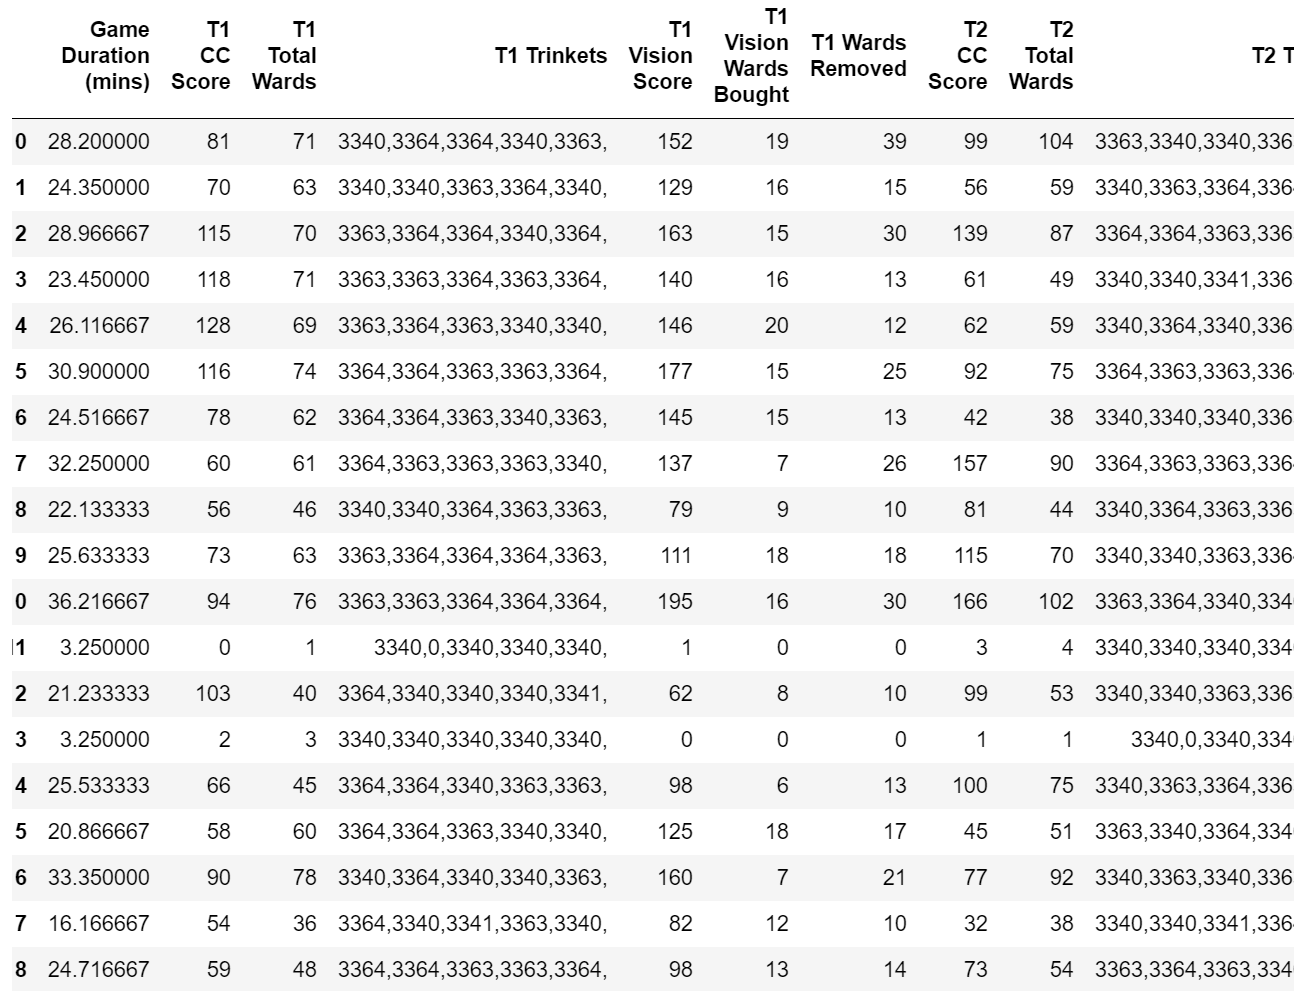

In [14]:
Image(filename='./three.png')

**Feature Explanation**

_Game Duration:_ The total time of the game in question.

_Total Wards:_ Wards are part of what add to a player's, and thereby team's, vision score. This is the total amount of wards a particular player put down on the game's map.

_Vision Wards Bought:_ These are how many vision wards a player bought. Since only a specific type of vision ward is availble to buy in-game (and the other is given free in form of a trinket), its score is not necessarily correlated with Total Wards amount (Vision Wards Bought is usually lower).

_Wards Removed:_ This is how many of the enemy wards a player, and thereby team, removed.

_Vision Score:_ This is a total of the above three (Total Wards, Vision Wards Bought, and Wards Removed). This is a weighted score, and puts emphasis on how useful the placed ward was (how many enemies were seen), and how many enemy wards were removed.

_Trinkets:_ The free vision item. Most wards placed are a trinket. Some trinkets allow for revealing (and subsequently removing) enemy wards. This feature was hard to translate into a number and I ended up removing it before making the final model.

_T1/T2:_ Team 1 and Team 2, respectively.

_CC Score:_ This is the amount of time a player used crowd-control (stun, slow, etc.) on the enemy players. This isn't related to vision directly, but indirectly I thought that more vision of a team might give greater opportunities for CC.  

_Team1 Win?/Team2 Win?:_ True or False according to which team won.

_What is a ward?_ It is an item in League of Legends that can be placed to secure vision in fog of war. The more enemies a ward spot, the more useful it is, and the more points get added to vision score.

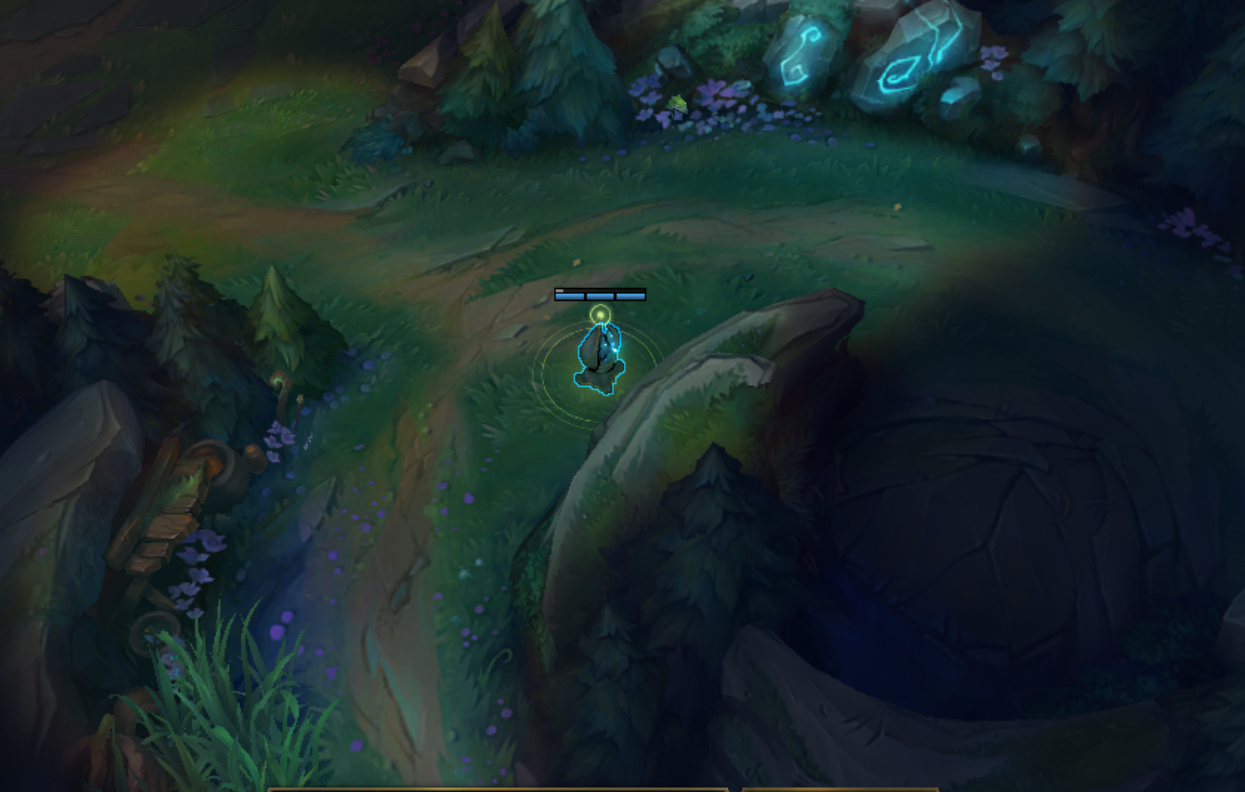

In [19]:
Image(filename='./seven.png')

## Data Cleanup and Exploration

**Cleaning the DF**

Wins/Losses were a Boolean value, but to be able to put them into a model, or even to put them into charts more easily, I wanted to change the True/False to 1/0. 

The other issue I had was that there was a blank first row from when I created the df, which needed to be deleted.

The following function cleaned the df of the aforementioned issues.

In [ ]:
def cleanDF(df):
    df = df_copy[1:]
    df.replace(True, 1, inplace=True)
    df.replace(False, 0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

Side note: The Game Duration feature was in seconds. This was fixed by adding:

```gamedur = gamedur/60```

to the getMatchInfo function. The Game Duration in the df is displayed in minutes.

**Charts**

I wanted to put the df on a heatmap to see what it might say about the correlation of Team 1's wins and the other features.

In [1]:
def make_heatmap(df):
    corr = df.corr()

    fig, ax = plt.subplots(figsize=(16,14))

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    plt.show()

```make_heatmap(df)```

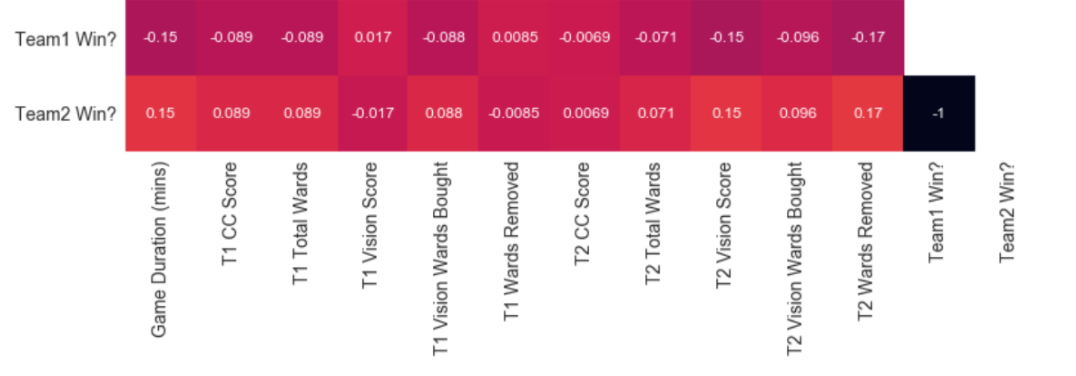

In [20]:
Image(filename='./four.png')

The resulting heatmap doesn't show an apparent correlation here, at this point it wasn't looking good. I wanted to continue on to make a model to see if it would reflect the heatmap or illuminate some correlation.

## Model Creation

For our model, we want to use our features to predict Team 1's Wins.

Team 1's Wins/Losses will be our y value, and X will include Game Duration along with the vision features, but only those for Team 1. 

**Baseline**

Taking our y, aka our Team 1's wins, we'll create a baseline by taking the total amount of wins and dividing them by the total amount of games. The score shows us a baseline, the percentage of wins over losses in the df. We want our model's score to beat the baseline score because that shows us our model is better than the average distribution of wins/losses.

In [ ]:
Baseline = y.sum()/len(y)

```0.48```

**Train Test Split**

As per usual, I split the X and the y so that there's a training set, the set that I build (or _train_) the model on, and a testing set, the set that I can test the model on to make sure it's not overfitted onto the training model.

In [ ]:
from sklearn.model_selection import train_test_split

X = df[['Game Duration (mins)', 'T1 CC Score', 'T1 Total Wards',
       'T1 Vision Score', 'T1 Vision Wards Bought', 'T1 Wards Removed']].copy()
y = df['Team1 Win?'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)

**Standard Scaler**

The features, aka X, need to be standardized. The ss (Standard Scalar) model is fitted only onto the X_train. Ss is used to transform both X_train and X_test. The reason X is standardized is because the features have different high and low values and limits, this makes sure the weight isn't based on said high number just because it's higher than another value's limit.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ssX_train = ss.fit_transform(X_train)
ssX_test = ss.transform(X_test)

**Logistic Regression**

Next, the model. I chose Logistic Regression for its simplicity. It can work with a smaller data set, and it's easy to understand what the score stands for, and thereby dissect it, which I'll do later. 

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(ssX_train, y_train)

lr.score(ssX_train, y_train)

```0.76000000000000001```

In consideration of the baseline (0.48), this is not a bad score. Let's see how our model does next on the test set.

In [ ]:
lr.score(ssX_test, y_test)

```0.64000000000000001```

Expectedly lower than the score on the training model. 64% isn't stunning, but is over the baseline and tells that there is some correlation between our vision data and wins. 

**Percsion & Recall**

Using the classification report, we can dissect the score futher into precision and recall. This will tell us how accurate the model is at predicting wins/losses on the test set, as well as false positive/negatives percentage.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_hat = lr.predict(ssX_test)
print(classification_report(y_test, y_hat))

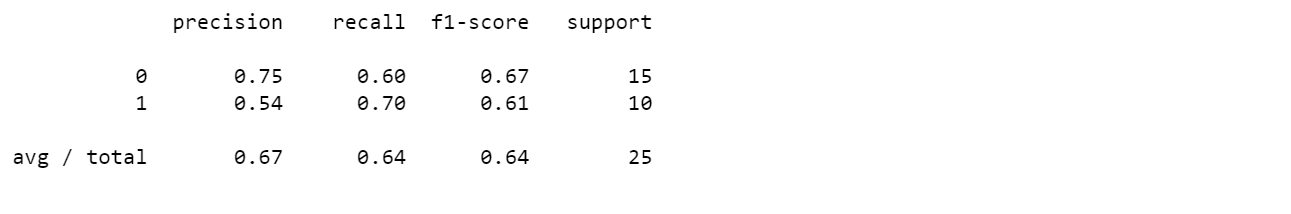

In [17]:
Image(filename='./six.png')

This model is better at predicting losses than wins, though there are more false negatives. This might indicate that vision is necessary to win, and that it's much harder to win without it, but a great vision score is not indicative of a win because it's one piece of a larger picture that needs to come together in order to win. 

Or so I assume.

Perhaps, another way I could see if vision is important is to compare team's scores at 10mins(early game) and 20mins(mid game) to see if greater vision during the earlier part of the game helps teams generate a lead. 

I think a lot can be done with this data. But, by itself, it does illuminate a little into where vision stands in this game. 